In [52]:
import os
import time
import cv2
from collections import Counter
from collections import OrderedDict
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.util import montage

from utils import quick_stats
from utils import get_gaussian_mask

%matplotlib inline
%reload_ext autoreload
%autoreload 2

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

MASK_METHOD = 'background'
CROP_SIZE = 96
N_COLOR_BINS = 3
N_IMAGE_CLUSTERS = 169
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
PATH = Path(ship_dir)
(PATH/f"train_{CROP_SIZE}").mkdir(exist_ok=True)

train_image_dir = os.path.join(ship_dir, 'train_768')
train_chip_dir = os.path.join(ship_dir, f"train_{CROP_SIZE}")
train_down_file = os.path.join(ship_dir, f"{MASK_METHOD}_768_down_{CROP_SIZE}.csv")
train_kmeans_file = os.path.join(ship_dir, f"{MASK_METHOD}_768_down_{CROP_SIZE}_{N_IMAGE_CLUSTERS}.csv")

In [2]:
# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i], padding_width=10, fill=[255, 255, 255]) for i in range(x.shape[3])], -1)
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
montage_pad = lambda x, *args, **kwargs: montage(x, padding_width=10, *args, **kwargs)

In [3]:
def centroid_histogram(clt, normalize=True):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
 
    # normalize the histogram, such that it sums to one
    if normalize:
        hist = hist.astype("float")
        hist /= hist.sum()
 
    return hist

def plot_colors(hist, centroids, height=50, width=300):
    # initialize the bar chart representing the relative frequency of each of the colors
    bar = np.zeros((height, width, 3), dtype = "uint8")
    startX = 0
 
    # loop over the percentage of each cluster and the color of each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * width)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), height), color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

In [76]:
train_down_file = os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}.csv")

In [4]:
df = pd.read_csv(train_down_file)
print(len(df))

149999


In [5]:
clt = KMeans(n_clusters=N_COLOR_BINS, n_init=5, n_jobs=1)

In [ ]:
crop_size = 96
# load the image and convert it from BGR to RGB so that we can dispaly it with matplotlib
img_id = np.random.choice(img_ids)
in_image = cv2.imread(os.path.join(train_image_dir, img_id))
in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB) / 255.

t0 = time.time()
in_vector = in_image.reshape((in_image.shape[0] * in_image.shape[1], 3))
clt.fit(in_vector)
hist = centroid_histogram(clt)
sindex = np.argsort(hist)[::-1]
hist = hist[sindex]
cluster_centers = (clt.cluster_centers_* 255).astype('uint8')
cluster_centers = cluster_centers[sindex]
quick_stats(in_image)
print(time.time() - t0, hist)
print(cluster_centers)

for crop_size in [384, 192, 96, 48, 24]:

    t0 = time.time()
    in_image_resized = resize(in_image, (crop_size, crop_size), mode='reflect', anti_aliasing=False)
    in_vector = in_image_resized.reshape((in_image_resized.shape[0] * in_image_resized.shape[1], 3))
    clt.fit(in_vector)
    hist = centroid_histogram(clt)
    sindex = np.argsort(hist)[::-1]
    hist = (hist[sindex] *255).astype('uint8')
    cluster_centers = (clt.cluster_centers_[sindex] * 255).astype('uint8')
    quick_stats(in_image_resized)
    print(time.time() - t0, hist)
    print(cluster_centers, cluster_centers.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(in_image)
ax1.set_title('Original Image')
ax2.imshow(in_image_resized)
ax2.set_title('Resized Image');

In [38]:
df = df.sample(20)
df = df.reset_index(drop=True)

In [7]:
img_ids = df['ImageId'].values
n_images = len(df)

score = np.zeros((N_COLOR_BINS, n_images), dtype='uint8')
r_mean = np.zeros((N_COLOR_BINS, n_images), dtype='uint8')
g_mean = np.zeros((N_COLOR_BINS, n_images), dtype='uint8')
b_mean = np.zeros((N_COLOR_BINS, n_images), dtype='uint8')

t1 = time.time()
crop_size = 24
# load the image and convert it from BGR to RGB so that we can dispaly it with matplotlib
for i, img_id in enumerate(img_ids):
#     t00 = time.time()
    in_image = cv2.imread(os.path.join(train_chip_dir, img_id))
#     t01 = time.time()
    in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB) / 255.
#     t02 = time.time()
    in_image_resized = resize(in_image, (crop_size, crop_size), mode='reflect', anti_aliasing=False)
#     in_image_resized = in_image
#     t03 = time.time()
    in_vector = in_image_resized.reshape((in_image_resized.shape[0] * in_image_resized.shape[1], 3))
#     t04 = time.time()
    clt.fit(in_vector)
#     t05 = time.time()
    hist = centroid_histogram(clt)
#     t06 = time.time()
    sindex = np.argsort(hist)[::-1]
#     t07 = time.time()
    hist = (hist[sindex] * 255).astype('uint8')
#     t08 = time.time()
    cluster_centers = (clt.cluster_centers_[sindex] * 255).astype('uint8')
#     t09 = time.time()
    
    if hist.shape[0] != N_COLOR_BINS:
        print(f'ALL BLACK??? {i}, {img_id}')
        print(hist)
        print(cluster_centers)
#         score[:, i] = (np.ones((N_COLOR_BINS,)) / N_COLOR_BINS * 255).astype('uint8')
#         r_mean[:, i] = np.array([0] * N_COLOR_BINS)
#         g_mean[:, i] = np.array([0] * N_COLOR_BINS)
#         b_mean[:, i] = np.array([0] * N_COLOR_BINS)
#     else:
    for j in range(N_COLOR_BINS):
        if hist.shape[0] <= j:
            score[j, i] = 0
            r_mean[j, i] = 0
            g_mean[j, i] = 0
            b_mean[j, i] = 0
        else:
            score[j, i] = hist[j]
            r_mean[j, i] = cluster_centers[j, 0]
            g_mean[j, i] = cluster_centers[j, 1]
            b_mean[j, i] = cluster_centers[j, 2]

    
#     t10 = time.time()
    if i == n_images - 1 or (i + 1) % 10000 == 0:
        print(i + 1, img_id, time.time() - t1)
#         quick_stats(in_image_resized)
#         print(time.time() - t0, hist)
#         print(t01 - t00)
#         print(t02 - t01)
#         print(t03 - t02)
#         print(t04 - t03)
#         print(t05 - t04)
#         print(t06 - t05)
#         print(t07 - t06)
#         print(t08 - t07)
#         print(t09 - t08)
#         print(t10 - t09)
#         print(t10 - t00)
#         print(cluster_centers)
        t1 = time.time()
#         break


1000 01a4b42b1_768.jpg 14.263015985488892
2000 036159544_768.jpg 14.044812679290771
3000 052212cd7_768.jpg 14.138470888137817
4000 06ce7986e_768.jpg 13.445961236953735
5000 087ee8041_768.jpg 14.690721273422241
6000 0a3ab4644_768.jpg 15.275495052337646
7000 0bdbf98cc_768.jpg 16.928399085998535
8000 0d9b3752f_768.jpg 14.865715265274048
ALL BLACK??? 8391, 0e4d7dd93_768.jpg
[85 85 85]
ALL BLACK??? 8792, 0ef6cd331_768.jpg
[85 85 85]
9000 0f4c1c7d7_768.jpg 17.052209615707397
10000 1106a058d_768.jpg 17.271036624908447
11000 12bd89671_768.jpg 15.163689374923706
12000 1474d115e_768.jpg 17.370779037475586
13000 162d782ff_768.jpg 15.656826496124268
14000 17df64ae9_768.jpg 16.403094053268433
15000 19912c752_768.jpg 16.331998109817505
16000 1b4ae7717_768.jpg 16.63222098350525
17000 1d07968c6_768.jpg 16.66353130340576
18000 1eb756d0d_768.jpg 17.414654970169067
19000 207522bb1_768.jpg 17.24308180809021
ALL BLACK??? 19058, 2095da0cb_768.jpg
[85 85 85]
ALL BLACK??? 19566, 2172218c8_768.jpg
[85 85 85]
2

In [6]:
np.array([0] * N_COLOR_BINS)
(np.ones((N_COLOR_BINS,)) / N_COLOR_BINS * 255).astype('uint8')

array([85, 85, 85], dtype=uint8)

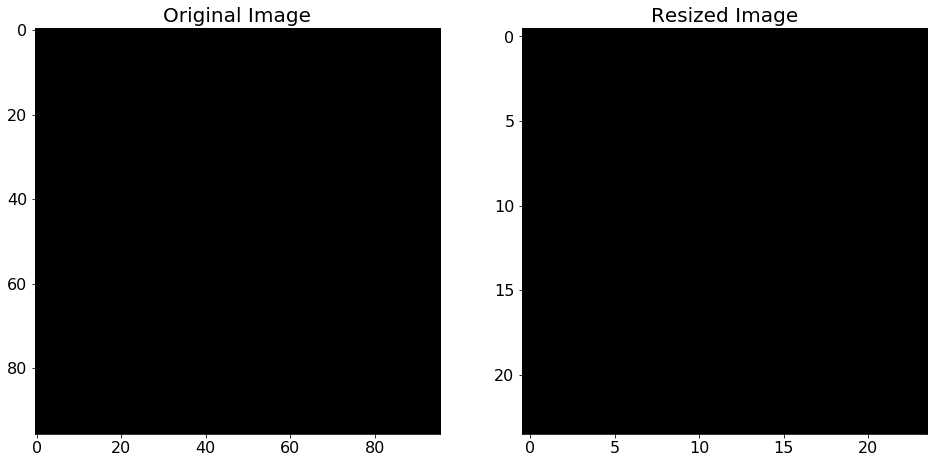

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(in_image)
ax1.set_title('Original Image')
ax2.imshow(in_image_resized)
ax2.set_title('Resized Image');

In [7]:
hist

array([212,  42], dtype=uint8)

In [8]:
# df = df[['ImageId', 'counts']]
for j in range(N_COLOR_BINS):
    df[f"hist_{j}"] = pd.Series(score[j], index=df.index)
    df[f"red_{j}"] = pd.Series(r_mean[j], index=df.index)
    df[f"green_{j}"] = pd.Series(g_mean[j], index=df.index)
    df[f"blue_{j}"] = pd.Series(b_mean[j], index=df.index)

In [9]:
df.head()

,counts,ImageId,r_mean,g_mean,b_mean,r_std,g_std,b_std,hist_0,red_0,green_0,blue_0,hist_1,red_1,green_1,blue_1,hist_2,red_2,green_2,blue_2
0,0,00003e153_768.jpg,0.106426,0.185318,0.295000,0.022300,0.019875,0.018002,125,28,48,76,112,23,43,72,17,41,59,84
1,0,0001124c7_768.jpg,0.505017,0.564821,0.584102,0.018197,0.016505,0.017019,112,127,142,147,103,132,147,152,39,120,137,141
2,0,0001b1832_768.jpg,0.440894,0.570919,0.582702,0.028362,0.025425,0.025011,93,112,146,149,83,104,138,141,77,120,152,155
3,0,0002d0f32_768.jpg,0.162252,0.192212,0.234490,0.217889,0.212318,0.192717,164,8,16,30,60,70,78,85,30,163,166,167
4,0,000303d4d_768.jpg,0.237266,0.256326,0.271250,0.078131,0.078122,0.078117,120,60,65,68,68,47,52,56,66,73,78,82


In [ ]:
df = pd.read_csv(train_down_file)
print(len(df))
df.head()

In [15]:
fields = ' '.join([f'hist_{i} red_{i} green_{i} blue_{i}' for i in range(N_COLOR_BINS)])

In [17]:
fields = fields.split()

In [18]:
fields

['hist_0',
 'red_0',
 'green_0',
 'blue_0',
 'hist_1',
 'red_1',
 'green_1',
 'blue_1',
 'hist_2',
 'red_2',
 'green_2',
 'blue_2']

In [20]:
df_stats = df[fields].values
print(df_stats.dtype, df_stats.shape)

uint8 (149999, 12)


In [ ]:
r_mean = defaultdict(int)
g_mean = defaultdict(int)
b_mean = defaultdict(int)
r_std = defaultdict(int)
g_std = defaultdict(int)
b_std = defaultdict(int)

t1 = time.time()
n_negs = len(negs_df)
for i, (src_img_id, tgt_img_id) in enumerate(img_ids):
    
    in_image = cv2.imread(os.path.join(train_chip_dir, src_img_id))
#     in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB) / 255.

    in_image_resized = resize(in_image, (CROP_SIZE, CROP_SIZE), mode='reflect', anti_aliasing=False)
    
    r0, g0, b0 = np.mean(in_image, axis=(0, 1))
    r1, g1, b1 = np.std(in_image, axis=(0, 1))

    r_mean[i] = r0
    g_mean[i] = g0
    b_mean[i] = b0
    r_std[i] = r1
    g_std[i] = g1
    b_std[i] = b1
    
    if i == n_negs - 1 or (i + 1) % 10000 == 0:
        print(i, tgt_img_id, time.time() - t1)
        t1 = time.time()

In [40]:
df = pd.read_csv(train_down_file)
print(len(df))
df.head()

fields_list = ['r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std', 'counts', 'n_pixels']
fields_set = set(fields_list)
fields_set.intersection_update(set(df))

if 'counts' in df:
    if df['counts'].max() == 0:
        fields_set.difference_update(set(('counts',)))
    else:
        assert df['counts'].min() == 1

if 'counts' not in fields_set or 'n_pixels' not in fields_set:
    fields_set.difference_update(set(('counts',)))
    fields_set.difference_update(set(('n_pixels',)))

fields = [f for f in fields_list if f in fields_set]

if 'counts' in df and 'n_pixels' in df:
    df = df[df['n_pixels'] > (CROP_SIZE / 24 * df['counts'])]  # Skip images with small ships. 4 pix min at res 96.
    df = df.reset_index(drop=True)
#     norm_counts = df['counts'] / np.linalg.norm(df['counts'])  # This dataset has at most 15 ships per image.
#     norm_pixels = df['n_pixels'] / np.linalg.norm(df['n_pixels'])
    df['pixel_weight'] = np.sqrt(df['n_pixels']) / CROP_SIZE
    fields.remove('counts')
    fields.remove('n_pixels')
    fields.append('pixel_weight')

df_stats = df[fields].values
print(df_stats.dtype, df_stats.shape)
df.describe()

149999
float64 (149999, 6)


,counts,r_mean,g_mean,b_mean,r_std,g_std,b_std
count,149999.0,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000,149999.000000
mean,0.0,0.201502,0.275143,0.318879,0.063008,0.059736,0.057481
std,0.0,0.192273,0.175417,0.151030,0.059760,0.054283,0.052713
min,0.0,0.001790,0.003405,0.003922,0.000000,0.000000,0.000000
25%,0.0,0.047434,0.145386,0.205971,0.018689,0.018763,0.018215
50%,0.0,0.130842,0.233114,0.278924,0.045210,0.043610,0.041860
75%,0.0,0.311426,0.381163,0.394340,0.084145,0.080678,0.077743
max,0.0,1.000000,1.000000,1.000000,0.482402,0.483688,0.438678


In [53]:
clt = MiniBatchKMeans(n_clusters=N_IMAGE_CLUSTERS, n_init=48, init_size=800)

In [66]:
clt = KMeans(n_clusters=N_IMAGE_CLUSTERS, n_init=48, n_jobs=8)

In [67]:
t0 = time.time()
clt.fit(df_stats)
print(time.time() - t0)

561.7913265228271


In [68]:
df['ClusterId'] = pd.Series(clt.labels_, index=df.index)
df.head()

,counts,ImageId,r_mean,g_mean,b_mean,r_std,g_std,b_std,hist_0,red_0,...,blue_0,hist_1,red_1,green_1,blue_1,hist_2,red_2,green_2,blue_2,ClusterId
0,0,00003e153_768.jpg,0.106426,0.185318,0.295000,0.022300,0.019875,0.018002,125,28,...,76,112,23,43,72,17,41,59,84,10
1,0,0001124c7_768.jpg,0.505017,0.564821,0.584102,0.018197,0.016505,0.017019,112,127,...,147,103,132,147,152,39,120,137,141,1
2,0,0001b1832_768.jpg,0.440894,0.570919,0.582702,0.028362,0.025425,0.025011,93,112,...,149,83,104,138,141,77,120,152,155,48
3,0,0002d0f32_768.jpg,0.162252,0.192212,0.234490,0.217889,0.212318,0.192717,164,8,...,30,60,70,78,85,30,163,166,167,73
4,0,000303d4d_768.jpg,0.237266,0.256326,0.271250,0.078131,0.078122,0.078117,120,60,...,68,68,47,52,56,66,73,78,82,126


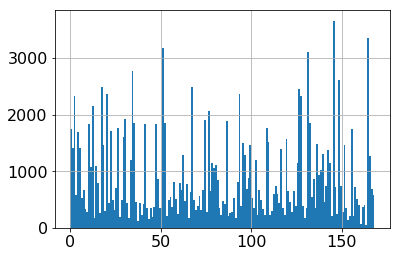

In [69]:
df['ClusterId'].hist(bins=df['ClusterId'].max());

In [77]:
train_kmeans_file = os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}_24.csv")
df.to_csv(train_kmeans_file, index=False)

In [46]:
df.to_csv(train_kmeans_file, index=False)

In [27]:
np.sqrt(len(df))

387.2970436241413

## Visually check the results

In [47]:
hist = centroid_histogram(clt)
cluster_centers = (clt.cluster_centers_* 255).astype('uint8')
bar = plot_colors(hist, cluster_centers[:, :3], height=50, width=800)

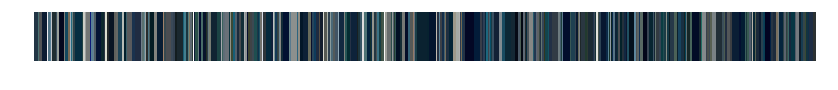

In [48]:
plt.figure(figsize=(14, 1))
plt.axis("off")
plt.imshow(bar)
plt.show()

In [70]:
cluster_groups = defaultdict(list)
for i, cluster_id in enumerate(df['ClusterId'].values):
    cluster_groups[cluster_id].append(i)
img_ids_new = df['ImageId'].values
bin_sizes = {tag: len(val) for tag, val in cluster_groups.items()}

In [71]:
sorted_bin_sizes = sorted(bin_sizes.items(), key=lambda x: x[1])
for k, v in sorted_bin_sizes:
    print(k, v)

163 46
160 66
37 127
153 138
43 159
129 167
32 170
65 175
91 178
13 178
27 195
45 197
144 202
167 202
87 203
156 213
154 214
53 216
83 219
118 220
110 221
103 226
39 228
107 231
59 236
147 241
88 263
16 268
9 271
122 271
150 273
75 274
89 282
19 294
111 300
72 307
69 320
24 322
8 331
106 332
152 344
50 346
42 347
44 347
82 350
117 350
101 352
49 353
130 355
135 356
46 361
56 362
161 367
168 376
124 381
70 382
94 391
128 392
162 405
159 405
85 418
40 419
38 440
115 441
31 445
21 446
140 453
36 454
121 454
63 468
84 471
68 488
23 495
105 496
28 498
54 500
58 508
158 515
6 521
100 521
90 523
55 549
133 551
71 554
3 584
112 589
114 605
66 637
77 646
120 655
123 659
61 664
104 666
73 672
7 676
97 678
166 694
25 699
146 714
157 725
141 731
113 742
149 747
64 780
15 797
60 800
57 803
92 803
81 843
48 858
134 858
98 874
137 934
138 1022
79 1053
11 1067
14 1089
80 1115
143 1138
125 1141
78 1146
33 1198
102 1206
165 1271
96 1280
62 1290
139 1297
142 1383
116 1395
1 1418
5 1418
18 1455
151 1456
9

In [ ]:
df[df['ClusterId'] == 58]

In [72]:
cluster_ids = [""] * N_IMAGE_CLUSTERS
samples_random = np.empty((N_IMAGE_CLUSTERS, CROP_SIZE, CROP_SIZE, 3), dtype='uint8')
samples_pseudo = np.empty((N_IMAGE_CLUSTERS, CROP_SIZE, CROP_SIZE, 3), dtype='uint8')
for cluster_id, cluster_group in cluster_groups.items():
    sub_idx = np.random.choice(len(img_ids_new))
    img_id = img_ids_new[sub_idx]
    in_image = cv2.cvtColor(cv2.imread(os.path.join(train_chip_dir, img_id)), cv2.COLOR_BGR2RGB)
    samples_random[cluster_id] = in_image
    
    sub_idx = np.random.choice(cluster_group)
    img_id = img_ids_new[sub_idx]
    cluster_ids[cluster_id] = img_id
    in_image = cv2.cvtColor(cv2.imread(os.path.join(train_chip_dir, img_id)), cv2.COLOR_BGR2RGB)
    samples_pseudo[cluster_id] = in_image

(169, 96, 96, 3)
(1248, 1248, 3)


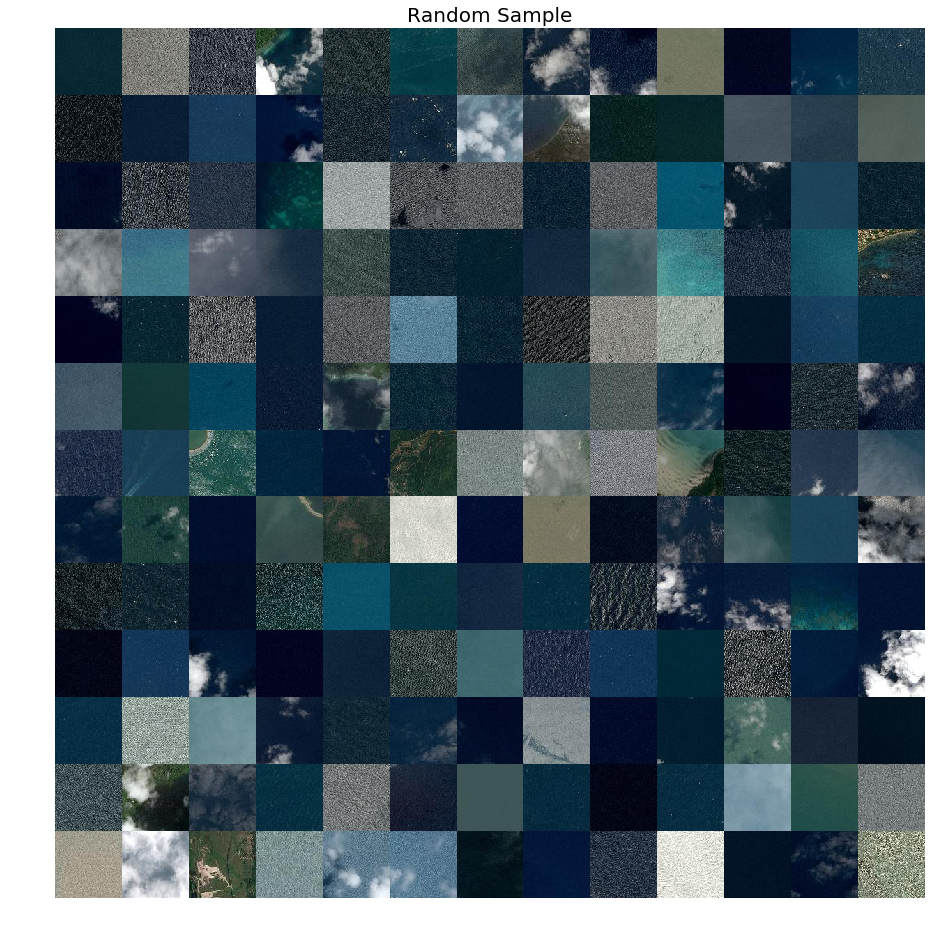

In [73]:
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
print(samples_random.shape)
batch_rgb = montage_rgb(samples_random)
print(batch_rgb.shape)
ax.imshow(batch_rgb)
ax.set_title('Random Sample')
plt.axis('off')
plt.show()

(169, 96, 96, 3)
(1248, 1248, 3)


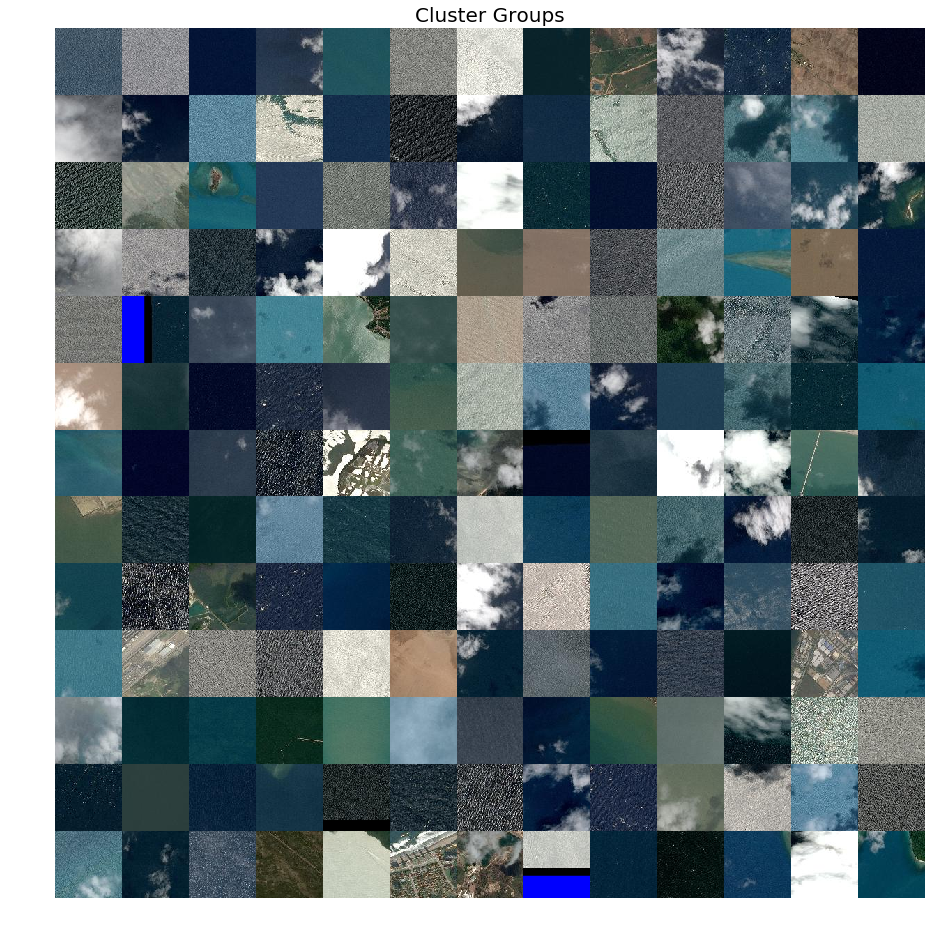

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
print(samples_pseudo.shape)
batch_rgb = montage_rgb(samples_pseudo)
print(batch_rgb.shape)
ax.imshow(batch_rgb)
ax.set_title('Cluster Groups')
plt.axis('off')
plt.show()

In [36]:
cluster_ids = [""] * N_IMAGE_CLUSTERS
for i in range(20):
    hard_negs = np.empty((N_IMAGE_CLUSTERS, CROP_SIZE, CROP_SIZE, 3), dtype='uint8')
    for cluster_id, cluster_group in cluster_groups.items():
        sub_idx = np.random.choice(len(cluster_group), 1)
        img_id = img_ids_new[cluster_group[sub_idx[0]]]
        cluster_ids[cluster_id] = img_id
        in_image = cv2.cvtColor(cv2.imread(os.path.join(train_chip_dir, img_id)), cv2.COLOR_BGR2RGB)
        hard_negs[cluster_id] = in_image

    batch_rgb = montage_rgb(hard_negs)
    if batch_rgb.shape[0] > 1920:
        batch_rgb = resize(batch_rgb, (1920, 1920), mode='reflect', anti_aliasing=False)
        batch_rgb = np.array(batch_rgb * 255, dtype=np.uint8)
        
    batch_bgr = cv2.cvtColor(batch_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(
        os.path.join(ship_dir, f"{MASK_METHOD}_768_down_{CROP_SIZE}_{N_IMAGE_CLUSTERS}_{i}.png"), 
        batch_bgr)


In [78]:
n = 36
for j, (cluster_id, cluster_size) in enumerate(sorted_bin_sizes):
    cluster_group = cluster_groups[cluster_id]
    sub_idxs = np.random.choice(cluster_group, n, replace=False)
    samples_pseudo = np.empty((n, CROP_SIZE, CROP_SIZE, 3), dtype='uint8')
    for i, sub_idx in enumerate(sub_idxs):
        img_id = img_ids_new[sub_idx]
        filename = os.path.join(train_chip_dir, img_id)
#         print(filename)
        samples_pseudo[i] = cv2.imread(filename)

    batch_rgb = montage_rgb(samples_pseudo)
    if batch_rgb.shape[0] > 1920:
        batch_rgb = resize(batch_rgb, (1920, 1920), mode='reflect', anti_aliasing=False)
        batch_rgb = np.array(batch_rgb * 255, dtype=np.uint8)
    cv2.imwrite(
        os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}_{j}_{cluster_size}_{cluster_id}.png"), 
        batch_rgb)
    
    if (j + 1) % 10 == 0:
        print(j + 1)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


In [48]:
batch_rgb = montage_rgb(hard_negs)

In [50]:
batch_rgb = resize(batch_rgb, (1920, 1920), mode='reflect', anti_aliasing=False)